# **Project Pipeline**

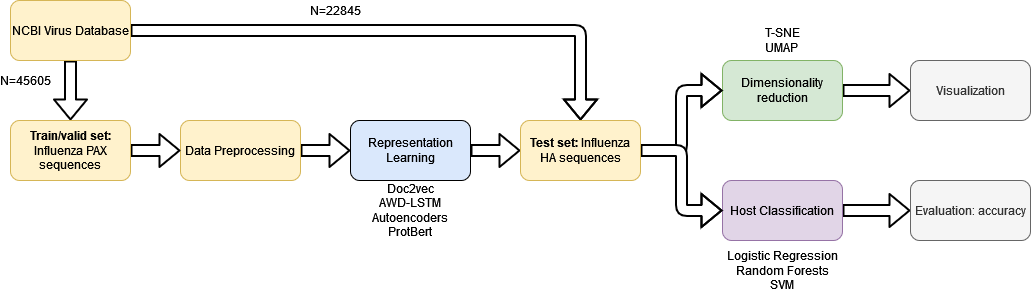

In this notebook, we use the Pretrained ProtBert models to extract viral protein embeddings, that we later visualize them by applying dimensionalilty reduction, or use them to determine the predicted host for the influenza A virus.

We start by installing some libraries that are not pre-installed on colab

In [ ]:
!pip install -q transformers
!pip install -q sentencepiece
!pip install -q Bio 
!pip install -q umap-learn > /dev/null

     |████████████████████████████████| 2.9 MB 5.4 MB/s 
     |████████████████████████████████| 636 kB 46.1 MB/s 
     |████████████████████████████████| 3.3 MB 30.9 MB/s 
     |████████████████████████████████| 56 kB 4.8 MB/s 
     |████████████████████████████████| 895 kB 27.5 MB/s 
     |████████████████████████████████| 109 kB 49.4 MB/s 
     |████████████████████████████████| 546 kB 45.7 MB/s 
     |████████████████████████████████| 1.2 MB 5.3 MB/s 


In [ ]:
import torch
from transformers import AutoTokenizer, AutoModel, pipeline, AlbertModel, AlbertTokenizer
import re
import numpy as np
from tqdm.notebook import tqdm
import pandas as pd 
from sklearn.manifold import TSNE
import umap
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from Bio import SeqIO

In [ ]:
# data resides in colab so we need to mount it
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = Path('/content/drive/MyDrive/PFE/')

### seed

In [ ]:
import random
def random_sd(use_seed=0):
    seed = use_seed if use_seed else random.randint(1,1000000)
    print(f"Using seed: {seed}")

    # python RNG
    random.seed(seed)

    # pytorch RNGs
    torch.manual_seed(seed)
    if torch.cuda.is_available(): torch.cuda.manual_seed_all(seed)
    if use_seed:
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark     = False

    # numpy RNG
    np.random.seed(seed)

    return seed

# set to 0 to be in random mode, or to a specific value if you want a specific reproducible case
# bad_seed = 0
# #bad_seed = 5079
# random_sd(bad_seed)

We ilustrate the inference process of ProtBert as following :


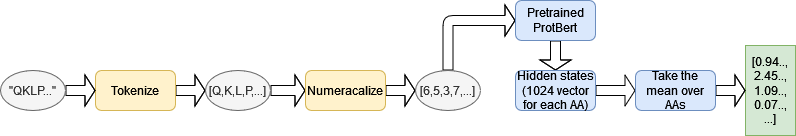

### Fasta to csv
Protein sequences exist in fasta format, we start by extarcting these sequences by relying on SeqIO from Bio library, then we merge them with their metadata and save the dataframe as a csv file.

In [ ]:
def fasta2csv(path, fasta_filename, meta_filename):
  records = SeqIO.parse(path/f'test_data/{fasta_filename}', 'fasta')

  ids = []
  seqs = []
  for record in records:
    ids.append(record.id)
    seqs.append(record.seq)

  df = pd.DataFrame(list(zip(ids, seqs)), columns=['ids', 'sequences'])
  df_meta = pd.read_csv(path/f'test_data/{meta_filename}')

  df = df.merge(df_meta, left_on='ids', right_on='accession')
  df.drop(columns='accession', inplace=True)

  return df

In [ ]:
df_pa = fasta2csv(path, 'FASTA_test_pa.fa', 'flu_test_pa.txt')
df_pa.to_csv(path/'test_data/df_test_pa.csv')

df_pb1 = fasta2csv(path, 'FASTA_test_pb1.fa', 'flu_test_pb1.txt')
df_pb1.to_csv(path/'test_data/df_test_pb1.csv')

df_pb2 = fasta2csv(path, 'FASTA_test_pb2.fa', 'flu_test_pb2.txt')
df_pb1.to_csv(path/'test_data/df_test_pb2.csv')

### Model
the embeddings are going to be extracted from a pretrained transformer based model, called **prot_bert**, its a bert model trained on millions of protein sequences and shared on HuggingFace model hub.

In [ ]:
# load data
df = pd.read_csv(path/'data/prot_sequences_influenza_ha_3_species.csv')
df['sequences'] = df['sequences'].apply(lambda x: ' '.join(x))
# # df['length'] = df['sequences'].map(lambda x : len(x))
# # df = df[df['length'] < 1000]
len(df)

22845

In [ ]:
# df_pa['sequences'] = df_pa['sequences'].apply(lambda x: ' '.join(x))
# df_pb1['sequences'] = df_pb1['sequences'].apply(lambda x: ' '.join(x))
# df_pb2['sequences'] = df_pb2['sequences'].apply(lambda x: ' '.join(x))

# df = pd.concat([df_pa, df_pb1, df_pb2])

By using the HuggingFace transformers library we can easily use pretrained models. the [prot_bert](https://huggingface.co/Rostlab/prot_bert) tokenizer treat each amino acid in the sequence as a single token resulting of a vocabulary size of 21, since the rare amino acids "U,Z,O,B" are mapped to "X".

In [ ]:
# prot_bert tokenizer
tokenizer = AutoTokenizer.from_pretrained("Rostlab/prot_bert", do_lower_case=False)

Downloading:   0%|          | 0.00/86.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/361 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/81.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [ ]:
# loading the pretrained model
model = AutoModel.from_pretrained("Rostlab/prot_bert")

Downloading:   0%|          | 0.00/1.57G [00:00<?, ?B/s]

Some weights of the model checkpoint at Rostlab/prot_bert were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

In [ ]:
# # getting a list of sequences after mapping the rare sequences to X
# pa_sequences = df_pa['sequences'].map(lambda x: re.sub(r"[UZOB]", "X", x)).tolist()
# pb1_sequences = df_pb1['sequences'].map(lambda x: re.sub(r"[UZOB]", "X", x)).tolist()
# pb2_sequences = df_pb2['sequences'].map(lambda x: re.sub(r"[UZOB]", "X", x)).tolist()

sequences = df['sequences'].map(lambda x: re.sub(r'[UZOP]', 'X', x)).tolist()

### Extracting protein representations from the model


In [ ]:
def extract_embeddings(model, tokenizer, sequences, batch_size=64):
  prot_embeddings = []
  cls_embeddings = []
  for i in tqdm(range(0, len(sequences), batch_size)):
    # when the number of sequences left is less than batch_size
    if (len(sequences) - i) < batch_size:
      batch_size = len(sequences) - i

    batch_sequences = sequences[i:i+batch_size]
    # tokenize sequences, add special tokens and apply padding 
    encoded_input = tokenizer(batch_sequences, return_tensors='pt', padding=True)
    tokenized_sequences = encoded_input["input_ids"].to(model.device)
    attention_mask = encoded_input["attention_mask"].to(model.device)

    with torch.no_grad():
      embeddings = model(
          input_ids=tokenized_sequences, attention_mask=attention_mask
      )
    seq_embeddings = embeddings[0].cpu().numpy()
    cls_embeddings.extend(embeddings[1].cpu().numpy())

    #remove special tokens(cls and sep tokens) and padding
    for seq_num in range(len(seq_embeddings)):
        seq_len = len(batch_sequences[seq_num].replace(" ", ""))
        start_Idx = 1
        end_Idx = seq_len+1
        seq_emd = seq_embeddings[seq_num][start_Idx:end_Idx]
        # we take the mean to get a representation of the whole protein
        prot_embeddings.append(seq_emd.mean(0))
  
  return prot_embeddings, cls_embeddings

Bert models return 2 outputs, one is a 2d array where each token in the input is mapped to a vector of size 1024, resulting in an matrix of size (number of tokens in the sequence, 1024), the other output is the embedding of the \[CLS] token. The \[CLS] token is added at the beggining of each input and is used for next sentence prediction during Bert training which makes it useful for classification tasks.

In [ ]:
prot_embeddings, cls_embeddings = extract_embeddings(model, tokenizer, sequences, 128)

  0%|          | 0/179 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [ ]:
np.save(path/'embeddings/prot_embeddings.npy', prot_embeddings)

# **Dimentionality Reduction**

We assessed the information captured by the embeddings extracted from the viral protein sequences using AWD-LSTM by projecting the high dimensional representations in two dimensional space (2D), using TSNE and UMAP. Toward this end, we choose to visualize the influenza A protein representations according to three major hosts (Human, Swine, Avian).

# 1- TSNE Projection

Using TSNE for dimentionality reduction with a number of iterations set to 3000 as in the [ProtTrans](https://www.biorxiv.org/content/10.1101/2020.07.12.199554v2.full.pdf) paper.



In [ ]:
embeds_2d = TSNE(n_components=2, n_iter=3000, random_state=42).fit_transform(prot_embeddings)

In [ ]:
np.save(path/"embeddings/embeds_2d.npy", embeds_2d)

We visualize the resulting 2D array and choose the hue to be based on **protein** or any other column.



/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


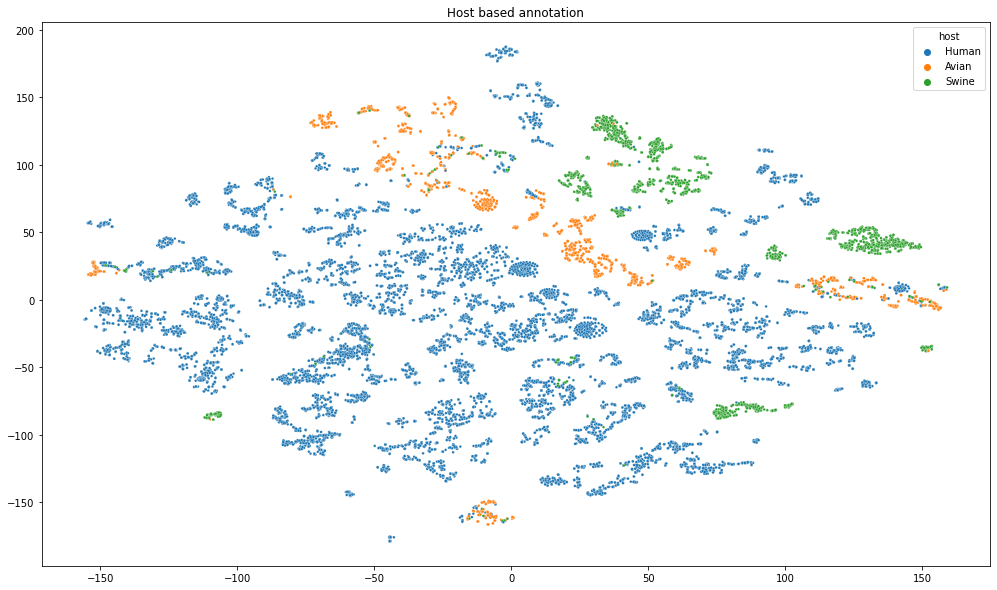

In [ ]:
fig, ax = plt.subplots(figsize=(17, 10))
ax.set_title('Host based annotation')
sns.scatterplot(embeds_2d[:, 0], embeds_2d[:, 1], hue=df['host'], s=7)

In [ ]:
df['date'] = df['date'].fillna(1900)
df['date'] = pd.to_datetime(df['date'])

dat = (df['date'].dt.year/10).apply(lambda x: int(x))
mon = (df['date'].dt.month)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


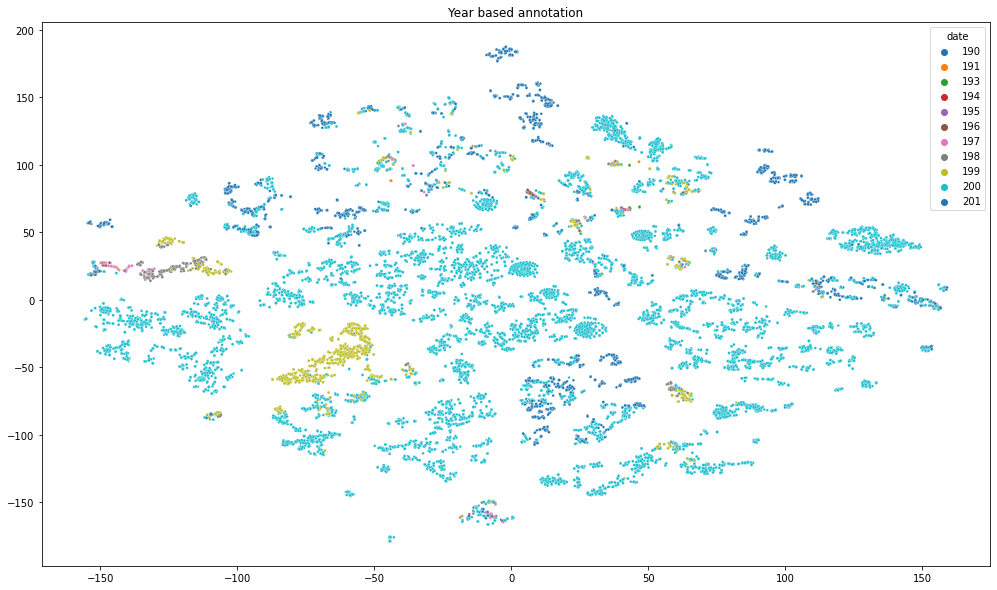

In [ ]:
fig, ax = plt.subplots(figsize=(17, 10))
ax.set_title('Year based annotation')
sns.scatterplot(embeds_2d[:, 0], embeds_2d[:, 1], hue=dat, s=7, palette='tab10')

# 2- *UMAP* Projection

In [ ]:
reducer = umap.UMAP(n_components=2, n_neighbors=20, min_dist=0.5, random_state=42)

NameError: ignored

In [ ]:
umap_embeds_2d = reducer.fit_transform(prot_embeddings)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


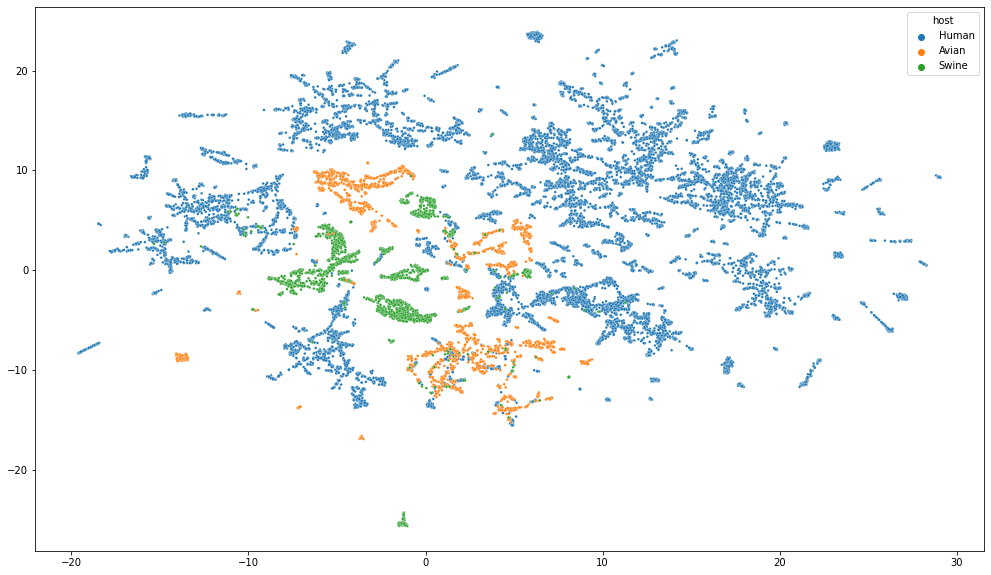

In [ ]:
fig, ax = plt.subplots(figsize=(17, 10))
sns.scatterplot(umap_embeds_2d[:, 0], umap_embeds_2d[:, 1], hue=df['host'], s=7)

In [ ]:
prot_embeddings = np.load(path/'embeddings/prot_embeddings.npy')

# **Protein Host Prediction**

To compare the representations produced by each model, we build different classifiers that use these representations as input to classify the sequences into three possible hosts that are Human, Swine or Avian.

# Classifiers

 Since the data is imbalanced with most sequences coming from human hosts, we balance our data using SMOTE (Synthetic Minority Oversampling Technique), where we do oversampling of the minority classes, SMOTE does this by synthesizing the samples along the class decision boundary. 

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

X, y = prot_embeddings, df['host']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
y_train.value_counts()

Human    12235
Avian     1968
Swine     1788
Name: host, dtype: int64

In [ ]:
y_test.value_counts()

Human    5274
Avian     831
Swine     749
Name: host, dtype: int64

In [ ]:
# balance data with smote
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train, y_train)

X.shape, X_res.shape

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


((22845, 1024), (36705, 1024))

In [ ]:
len(y_res[y_res=='Human']), len(y_res[y_res=='Avian']), len(y_res[y_res=='Swine'])

(12235, 12235, 12235)

After oversampling, we split the data randomly into train and test set, we used 30% of the data for testing the model, and the rest for training.

**Logistic Regression**

In [ ]:
# logistic regression
clf = LogisticRegression(random_state=42).fit(X_res, y_res)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [ ]:
clf.score(X_test, y_test)

0.9709658593522031

In [ ]:
# f1 score
from sklearn.metrics import f1_score

y_pred = clf.predict(X_test)

f1_score(y_test, y_pred, average='macro')

0.9491064438511918

In [ ]:
# auc

from sklearn.metrics import roc_auc_score

roc_auc_score(y_test, clf.predict_proba(X_test), multi_class='ovo')

0.9956870067599938

**Random Forest**

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification


clf = RandomForestClassifier(max_depth=10, random_state=0)
clf.fit(X_res, y_res)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [ ]:
clf.score(X_test, y_test)

0.9823460752845053

In [ ]:
# f1 score
from sklearn.metrics import f1_score

y_pred = clf.predict(X_test)

f1_score(y_test, y_pred, average='macro')

0.9678069849306551

In [ ]:
# auc

from sklearn.metrics import roc_auc_score

roc_auc_score(y_test, clf.predict_proba(X_test), multi_class='ovo')

0.9975635018829325

**Support Vector Machine**


In [ ]:

from sklearn.svm import LinearSVC
# from sklearn.preprocessing import StandardScaler

clf = LinearSVC(random_state=0, tol=1e-5)
clf.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=0, tol=1e-05,
          verbose=0)

In [ ]:
clf.score(X_test, y_test)

0.9848975188781014

In [ ]:
# f1 score
from sklearn.metrics import f1_score

y_pred = clf.predict(X_test)

f1_score(y_test, y_pred, average='macro')

0.9848691087205484

### Visualization with balancing

In [ ]:
embeds = TSNE(n_components=2, n_iter=3000).fit_transform(X_res)

In [ ]:
len(embeds), len(y_res)

(52527, 52527)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


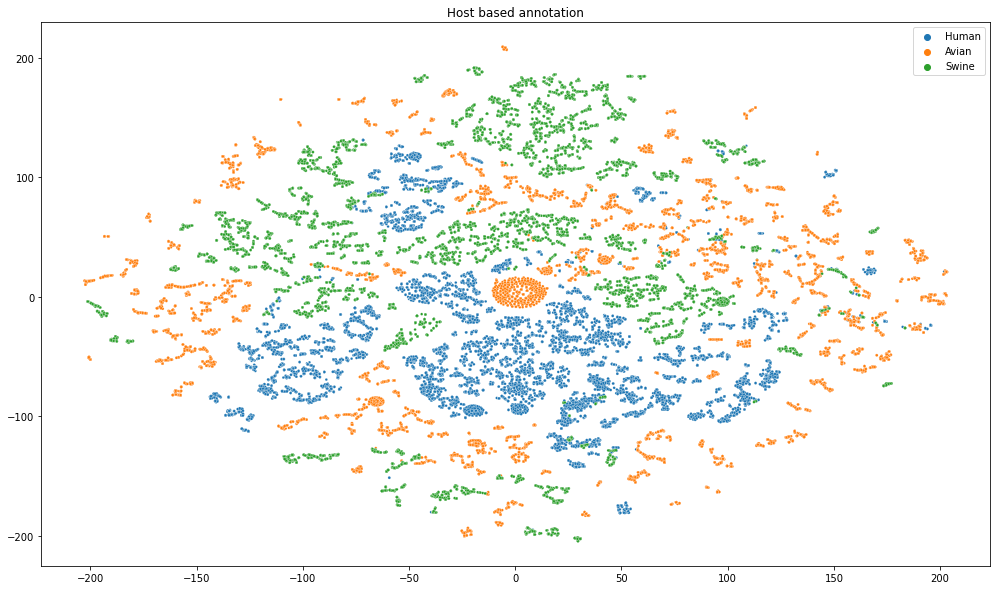

In [ ]:
fig, ax = plt.subplots(figsize=(17, 10))
ax.set_title('Host based annotation')
sns.scatterplot(embeds[:,0], embeds[:, 1], hue=y_res, s=7)

In [ ]:
reducer = umap.UMAP(n_components=2, n_neighbors=20, min_dist=0.5, random_state=42)

In [ ]:
umap_embeds_2d = reducer.fit_transform(X_res)

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


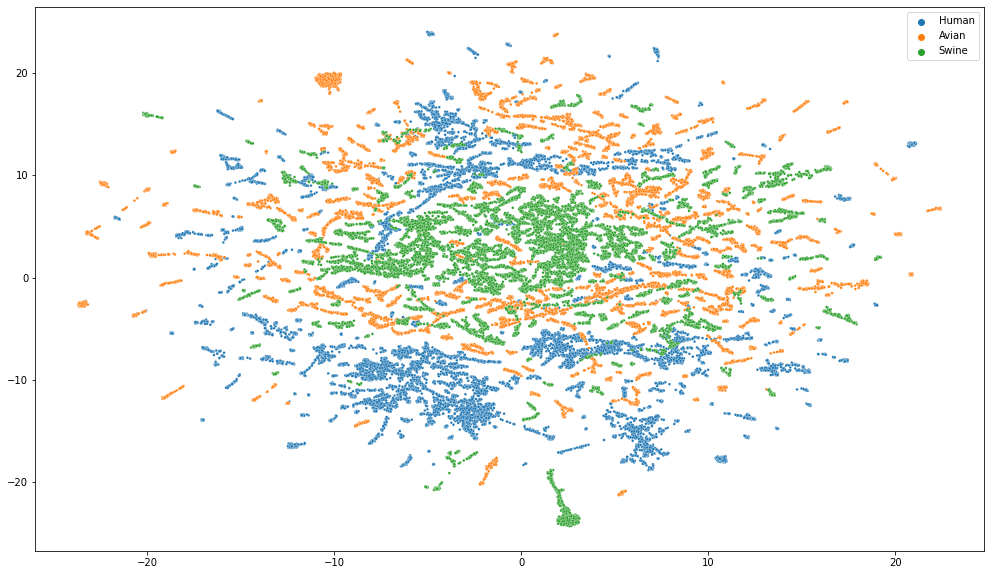

In [ ]:
fig, ax = plt.subplots(figsize=(17, 10))
sns.scatterplot(umap_embeds_2d[:, 0], umap_embeds_2d[:, 1], hue=y_res, s=7)